In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import StratifiedKFold


In [2]:
df = pd.read_csv('/home/chris/Documents/Datasets/creditcard.csv')

In [3]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["Class"]):
    train_set = df.loc[train_index]
    test_set = df.loc[test_index]

train_set = train_set.reset_index(drop = True)
credit_card = train_set.copy()

splitcv = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=43)
for train_index, cv_index in splitcv.split(credit_card, credit_card["Class"]):
    train60_set = credit_card.loc[train_index]
    cv_set = credit_card.loc[cv_index]
    
train60_set = train60_set.reset_index(drop = True)
cv_set = cv_set.reset_index(drop = True)
credit_card60 = train60_set.copy()
credit_card_cv = cv_set.copy()

In [4]:
m,n = credit_card60.shape
X_train60 = credit_card60.iloc[:,0:(n-1)]
y_train60 = credit_card60.iloc[:,n-1]
X_cv = credit_card_cv.iloc[:,0:(n-1)]
y_cv = credit_card_cv.iloc[:,n-1]

data = X_train60
scaler = StandardScaler()
scaler.fit(data)
X_train60_scaled = scaler.transform(data)

data = X_cv
scaler = StandardScaler()
scaler.fit(data)
X_cv_scaled = scaler.transform(data)

In [10]:
param_grid = [
    {'penalty':['l1', 'l2'], 'C':[0.01,0.03,0.1,0.3,1,3,10], 'class_weight':[None, 'balanced'] }
]
lgregclf = LogisticRegression()
grid_search = GridSearchCV(lgregclf, param_grid,scoring = 'average_precision' ,cv = 4,)
grid_search.fit(X_train60_scaled, y_train60)

GridSearchCV(cv=4, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'penalty': ['l1', 'l2'], 'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10], 'class_weight': [None, 'balanced']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='average_precision', verbose=0)

In [11]:
grid_search.best_params_, grid_search.best_score_

({'C': 0.1, 'class_weight': None, 'penalty': 'l2'}, 0.7767037802209503)

Text(0.5,1,'2-class Precision-Recall curve: AUC=0.75')

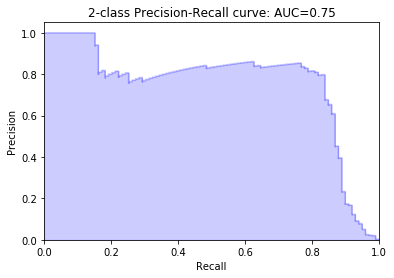

In [14]:
lgregclf = LogisticRegression(C = 0.1) #use best parameters here
lgregclf.fit(X_train60_scaled,y_train60)
y_cv_pred_prob = lgregclf.predict_proba(X_cv_scaled)

precision, recall, threshold = precision_recall_curve(y_cv, y_cv_pred_prob[:,1])
area_under_curve = auc(recall,precision)

plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AUC={0:0.2f}'.format(
          area_under_curve))

In [15]:
precision, recall, threshold

(array([0.00358566, 0.00354957, 0.0035497 , ..., 1.        , 1.        ,
        1.        ]),
 array([1.        , 0.98989899, 0.98989899, ..., 0.02020202, 0.01010101,
        0.        ]),
 array([6.29261670e-04, 6.29305307e-04, 6.29334915e-04, ...,
        9.99999978e-01, 9.99999982e-01, 9.99999995e-01]))

In [28]:
from imblearn.over_sampling import SMOTE, ADASYN
X_60resampled, y_60resampled = SMOTE(random_state=42).fit_sample(X_train60_scaled, y_train60)



In [29]:
X_60resampled.shape

(341176, 30)

In [30]:
import collections

collections.Counter(y_60resampled)

Counter({0: 170588, 1: 170588})

In [31]:
grid_search.fit(X_60resampled, y_60resampled)

GridSearchCV(cv=4, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'penalty': ['l1', 'l2'], 'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10], 'class_weight': [None, 'balanced']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='average_precision', verbose=0)

In [32]:
grid_search.best_params_, grid_search.best_score_

({'C': 10, 'class_weight': None, 'penalty': 'l2'}, 0.9907379568802471)

Text(0.5,1,'2-class Precision-Recall curve: AUC=0.99')

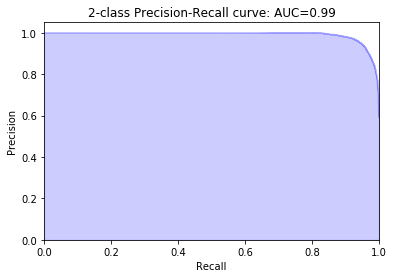

In [33]:
lgregclf = LogisticRegression(C = 10) #use best parameters here
lgregclf.fit(X_60resampled,y_60resampled)
y_60resampledpred = lgregclf.predict_proba(X_60resampled)

precision, recall, _ = precision_recall_curve(y_60resampled, y_60resampledpred[:,1])
area_under_curve = auc(recall,precision)

plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AUC={0:0.2f}'.format(
          area_under_curve))

Text(0.5,1,'2-class Precision-Recall curve: AUC=0.77')

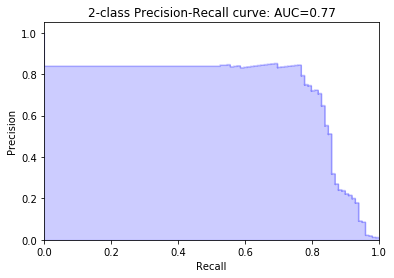

In [34]:
lgregclf = LogisticRegression(C = 10) #use best parameters here
lgregclf.fit(X_60resampled,y_60resampled)
y_cv_pred_prob = lgregclf.predict_proba(X_cv_scaled)

precision, recall, _ = precision_recall_curve(y_cv, y_cv_pred_prob[:,1])
area_under_curve = auc(recall,precision)

plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AUC={0:0.2f}'.format(
          area_under_curve))

In [35]:
X_train60_cnn_resampled = np.loadtxt("/home/chris/Documents/ml/credit-card-fraud/cnntrain60.csv",delimiter=",")
y_train60_cnn_resampled = np.loadtxt("/home/chris/Documents/ml/credit-card-fraud/cnnlabel60.csv",delimiter=",")

In [36]:
grid_search.fit(X_train60_cnn_resampled,y_train60_cnn_resampled)

GridSearchCV(cv=4, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'penalty': ['l1', 'l2'], 'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10], 'class_weight': [None, 'balanced']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='average_precision', verbose=0)

In [37]:
grid_search.best_params_, grid_search.best_score_

({'C': 1, 'class_weight': None, 'penalty': 'l1'}, 0.8979726547369691)

Text(0.5,1,'2-class Precision-Recall curve: AUC=0.70')

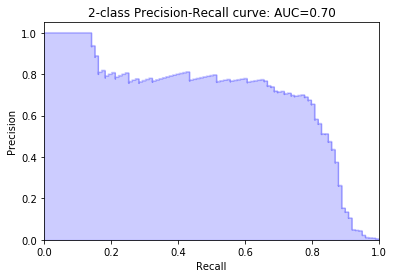

In [38]:
lgregclf = LogisticRegression(C = 1, penalty='l1') #use best parameters here
lgregclf.fit(X_train60_cnn_resampled,y_train60_cnn_resampled)
y_cv_pred_prob = lgregclf.predict_proba(X_cv_scaled)

precision, recall, _ = precision_recall_curve(y_cv, y_cv_pred_prob[:,1])
area_under_curve = auc(recall,precision)

plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AUC={0:0.2f}'.format(
          area_under_curve))

In [39]:
X_60resampled_no_time = X_60resampled[:,1:(n-1)]
X_cv_scaled_no_time = X_cv_scaled[:,1:(n-1)]

In [40]:
X_60resampled_no_time[0], X_60resampled[0], X_cv_scaled_no_time[0], X_cv_scaled[0]

(array([ 0.55451644, -0.73729517,  0.65582381, -0.26777598, -1.2671365 ,
        -0.33164039, -0.76361424, -0.02745097, -0.1220131 ,  0.40512635,
        -0.53078457, -0.39436145,  0.40266163, -0.74641093,  0.39511698,
         1.37316369,  0.3619038 , -1.20490236,  0.50735757,  0.48378449,
         0.52940318,  1.23450342, -0.37281662,  0.75257466,  0.79226016,
        -0.13053482,  0.05931106,  0.15328343,  0.25355433]),
 array([-1.07948521,  0.55451644, -0.73729517,  0.65582381, -0.26777598,
        -1.2671365 , -0.33164039, -0.76361424, -0.02745097, -0.1220131 ,
         0.40512635, -0.53078457, -0.39436145,  0.40266163, -0.74641093,
         0.39511698,  1.37316369,  0.3619038 , -1.20490236,  0.50735757,
         0.48378449,  0.52940318,  1.23450342, -0.37281662,  0.75257466,
         0.79226016, -0.13053482,  0.05931106,  0.15328343,  0.25355433]),
 array([ 0.78825009, -0.56936382,  0.09796876, -1.18331917, -0.66388021,
        -0.04893156, -0.80814235, -0.16100498, -1.70289981, 

Text(0.5,1,'2-class Precision-Recall curve: AUC=0.77')

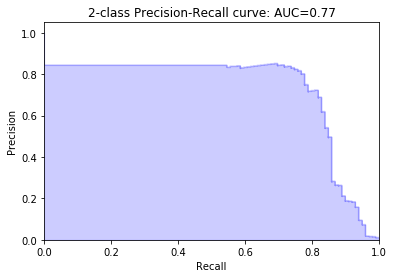

In [41]:
lgregclf = LogisticRegression(C = 10) #use best parameters here
lgregclf.fit(X_60resampled_no_time,y_60resampled)
y_cv_pred_prob = lgregclf.predict_proba(X_cv_scaled_no_time)

precision, recall, _ = precision_recall_curve(y_cv, y_cv_pred_prob[:,1])
area_under_curve = auc(recall,precision)

plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AUC={0:0.2f}'.format(
          area_under_curve))